In [2]:
import scipy
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt

## Solve Riccati ODE

In [116]:
# define riccati ode
def dPdt(P, t, A, B, Q, R, S,):
    if S is None:
        S = np.zeros((A.shape[0], B.shape[1]))

    return -(A.T @ P + P @ A - (P @ B + S) /R @ (B.T @ P + S.T) + Q)

In [201]:
# define system
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
Q = np.zeros((2, 2))
R1 = 1
PT = np.eye(2)
# PT = np.array([[1, 0], [0, 0]])
tspan = np.linspace(0, 1, 21)
tspan = np.flip(tspan)
K1 = odeintw(dPdt, PT, tspan, args=(A, B, Q, R1, None, ))

In [202]:
K1 = np.flip(K1, axis=0)

In [203]:
K_norm = [np.linalg.norm(K1[i, :, :]) for i in range(len(K1))]

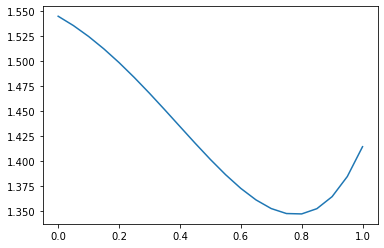

In [204]:
plt.plot(np.flip(tspan), K_norm)

## Solve Matrix ODE (Phi)

In [205]:
def dPhi(Phi, t, A):
    return np.dot(A, Phi)

A = np.array([[0, 1], [0, 0]])
t_span = np.linspace(0, 1, 21)
t_span = np.flip(t_span)
PhiT = np.eye(2)

Phi_sol = odeintw(dPhi, PhiT, t_span, args=(A, ))
Phi_sol = np.flip(Phi_sol, axis=0)

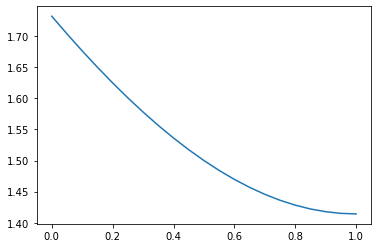

In [206]:
phi_norm = [np.linalg.norm(Phi_sol[i, :, :]) for i in range(len(Phi_sol))]
plt.plot(np.flip(t_span), phi_norm)

## Compute d_i

In [207]:
def d(Phi, K, B, R, z):
    ds = np.zeros((len(Phi), 1))
    for i in range(len(Phi)):
        ds[i] = z.T @ Phi[i, :, :] @ K[i, :, :] @ B/R @ B.T @ K[i, :, :] @ Phi[i, :, :] @ z

    return ds

In [208]:
z = np.array([[1], [0]])
d1 = d(Phi_sol, K1, B, R1, z)
R2 = 5
K2 = odeintw(dPdt, PT, tspan, args=(A, B, Q, R2, None, ))
K2 = np.flip(K2, axis=0)
d2 = d(Phi_sol, K2, B, R2, z)

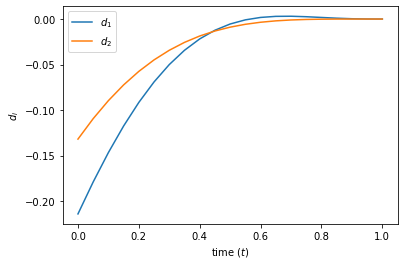

In [209]:
plt.plot(np.flip(t_span), d1, label='$d_1$')
plt.plot(np.flip(t_span), d2, label='$d_2$')
# plt.vlines(x=0.5, ymin=np.min(d1), ymax=np.max(d1), linestyles='--', colors='red')
plt.xlabel("time $(t)$")
plt.ylabel("$d_i$")
plt.legend()


If $d_1 - d_2$ is not constant, find the critical time $t_r$

In [210]:
def obj(tr):
    x0 = np.array([[0], [0]])
    term1 = np.sum((d1[:tr] - d2[:tr])*0.1)
    return term1

tr = np.linspace(0, 20, 21, dtype=np.int32)
objs = list(map(obj, tr))
tr_idx = np.argmin(objs)
tr = np.flip(t_span)[tr_idx]
f'tr = {tr}'

'tr = 0.45'

In [166]:
# to get T_{2p+1} we need to calculate two more things
# x_1i = np.array([[0], [0]])
# x_2i = np.array([[0], [0]])
# theta = 1  # theta = 1 or -1
# p_1 = (x_1i - Phi_sol[0, :, :] @ z * theta).T @ K1[0, :, :] @ (x_1i - Phi_sol[0, :, :] @ z * theta)
# p_2 = (x_2i - Phi_sol[0, :, :] @ z * theta).T @ K2[0, :, :] @ (x_2i - Phi_sol[0, :, :] @ z * theta)
#
# T_2p1 = tr + p_1 - p_2
# T_2p1

In [60]:
d1 - d2

array([[-0.19493176],
       [-0.00423266],
       [ 0.        ]])

## METHOD - 2  (Just to Ensure the solver above is correct!)

In [34]:
def mat2vec_ode(F, p):
    def state_vector_derivative(F, t, y, p):
        # state dimension
        pr = len(y)

        # determines r
        r = int(pr/p)

        # reshapes pr×1 state vector into p×r state matrix

        M = y.reshape(p, r)

        # evaluates matrix-valued ODE
        dMdt = F(t,M)

        # reshapes p×r state matrix derivative into pr×1 state vector derivative
        dydt = dMdt.flatten()

        return dydt

    return lambda t, y: state_vector_derivative(F, t, y, p)

In [35]:
def mat2vec_IC(PT):
    return PT.flatten()

In [63]:
def vec2mat_sol(y, p):
    # state dimension (pr) and N (IVP solution given at N+1 times)
    pr = y.shape[0]
    N = y.shape[1] - 1

    # determines r
    r = int(pr/p)

    # preallocate solution array to store time history of state matrix
    M = np.zeros((p, r, N+1))

    # populate solution array
    for i in range(N+1):
        M[:, :, i] = y[:, i].reshape(p, r)

    return M

In [144]:
def solve_ricatti_ode(A, B, Q, R, S, PT, tspan, teval):
    n = A.shape[0]
    m = B.shape[1]

    if S is None:
        S = np.zeros((n, m))

    tspan = np.flip(tspan)

    teval = np.flip(teval)

    dPdt = lambda t, P: -(A.T @ P + P @ A - (P @ B + S) /R @ (B.T @ P + S.T) + Q)

    dydt = mat2vec_ode(dPdt, n)

    yT = mat2vec_IC(PT)
    sol = scipy.integrate.solve_ivp(dydt, tspan, yT, atol=1e-9, rtol=1e-9, t_eval=teval)
    P = vec2mat_sol(sol.y, n)
    t = np.flip(sol.t)
    P = np.flip(P, axis=2)
    return (t, P)

In [152]:
# define states
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
Q = np.zeros((2, 2))
R = 1
PT = np.eye(2)
S = np.zeros((A.shape[0], B.shape[1]))
teval = np.linspace(0, 10, 73)
t, P = solve_ricatti_ode(A, B, Q, R, S, PT, [0, 10], teval)

In [153]:
P_norms = [np.linalg.norm(P[:, :, i]) for i in range(P.shape[-1])]

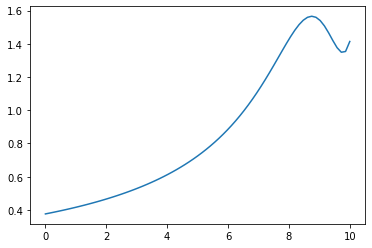

In [154]:
plt.plot(t, P_norms)